<a href="https://colab.research.google.com/github/rubanzasilva/academic_success/blob/main/s04e06_fastai%2BGBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification model to predict students' dropout and academic sucess.

The dataset contains information collected from a higher education institution related to students undertaking different degree programs.
The original dataset contains information known at the time of student enrollment and the student's academic perfromance at the end of the 1st and 2nd semester.

The target is split into three distinct categories namely Dropout, Enrolled and Graduate.

In this spirit, I shall build classification models using various architectures to predict the student's dropout and academic success.This can then be used to predict which students are most likely to drop out at an early stage so that strategies can be put in place to counter this.

That would help reduce the rate of academic dropout and failure.

## Import Libraries and Datasets

### Libraries

### Original Dataset

@misc{misc_predict_students'_dropout_and_academic_success_697,
  author       = {Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís},
  title        = {{Predict Students' Dropout and Academic Success}},
  year         = {2021},
  howpublished = {UCI Machine Learning Repository},
  note         = {{DOI}: https://doi.org/10.24432/C5MC89}
}

## Imports

Below, i import all the libraries and datasets needed for this competition.

In [1]:
!pip install catboost
!pip install optuna
!pip install optuna_distributed
!pip install openfe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [2]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp

import optuna
from openfe import OpenFE, transform

from IPython.display import FileLink



In [3]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"3c109650146efc9c92fc9e8bfe70d487"}'}

In [5]:
!ls

kaggle.json  sample_data


In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#!chmod 600 /root/.kaggle/kaggle.json

In [7]:
comp = 'playground-series-s4e6'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 3.07M/3.07M [00:00<00:00, 84.5MB/s]

In [8]:
#set_seed(42)

In [9]:

path = Path('playground-series-s4e6/')
path

Path('playground-series-s4e6')

### Import original dataset

In [10]:
! kaggle datasets download -d rubanzasilva/academic-success-dataset

Dataset URL: https://www.kaggle.com/datasets/rubanzasilva/academic-success-dataset
License(s): Apache 2.0
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 80.3MB/s]


In [11]:
!unzip academic-success-dataset.zip

Archive:  academic-success-dataset.zip
  inflating: data.csv                


In [12]:
!ls

academic-success-dataset.zip  kaggle.json	      playground-series-s4e6.zip
data.csv		      playground-series-s4e6  sample_data


# Experiment 2 - Dataframes with id as index

In [13]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
original_df = pd.read_csv('data.csv')

In [14]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Target')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Target',
                   y_block=CategoryBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

In [15]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

accuracy_score(y_test,rf_preds_x)

CPU times: user 17.1 s, sys: 76.6 ms, total: 17.2 s
Wall time: 25.3 s


0.8272234202443965

In [16]:
%%time
cat_model = CatBoostClassifier(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

accuracy_score(y_test,cat_preds_x)

CPU times: user 7min 51s, sys: 5.34 s, total: 7min 57s
Wall time: 5min 52s


0.8331699666732013

In [17]:
xgb_model = xgb.XGBClassifier(n_estimators = 197, max_depth=4, learning_rate=0.1818695751227044, subsample= 0.39774994666482544)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

accuracy_score(y_test,xgb_preds_x)

0.8338887799777821

In [18]:
lgb_model = lgb.LGBMClassifier(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = accuracy_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 61215, number of used features: 36
[LightGBM] [Info] Start training from score -1.110642
[LightGBM] [Info] Start training from score -1.636258
[LightGBM] [Info] Start training from score -0.742452


0.8283343135332941

In [19]:
test_df['Target'] = lgb_preds
test_df.to_csv('submission.csv', columns=['Target'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

,id,Target
0,76518,0
1,76519,2
2,76520,2
3,76521,1
4,76522,1


In [20]:
submission.shape

(51012, 2)

In [ ]:
#!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "lgb_preds trial 1"

SuggestedLRs(slide=0.019054606556892395, valley=0.0010000000474974513)

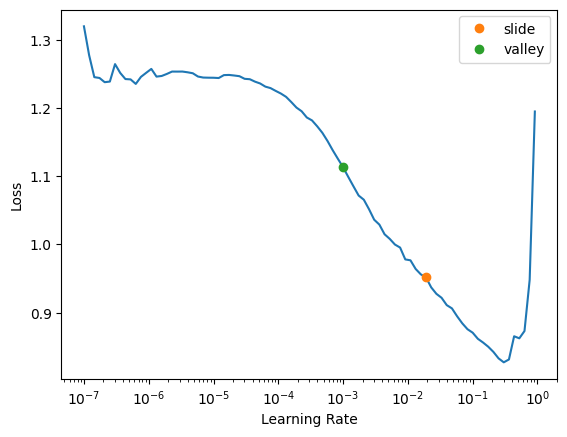

In [21]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find(suggest_funcs=(slide,valley))

In [22]:
%%time
learn.fit_one_cycle(10,0.012)

epoch,train_loss,valid_loss,accuracy,time
0,0.479648,0.488110,0.811998,00:15
1,0.484941,0.470329,0.815396,00:14
2,0.459059,0.458953,0.821800,00:14
3,0.467628,0.455914,0.826439,00:15
4,0.455727,0.455645,0.823891,00:14
5,0.455857,0.453048,0.823172,00:14
6,0.453326,0.449944,0.823433,00:14
7,0.437670,0.448528,0.824675,00:14
8,0.448815,0.450119,0.823956,00:14
9,0.434453,0.447282,0.826635,00:14


CPU times: user 2min 24s, sys: 855 ms, total: 2min 25s
Wall time: 2min 27s


In [26]:
%%time
dl = learn.dls.test_dl(test_df)
#nn_preds = learn.get_preds(dl=dl)


#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

IndexError: Target -1 is out of bounds.

In [24]:
nn_preds[0]

NameError: name 'nn_preds' is not defined

In [ ]:
nn_preds = learn.get_preds(dl=dl)
#nn_preds_x = learn.get_preds()[0]
#a_preds, _ = learn.get_preds(dl=dl)
#nn_preds_y = a_preds.squeeze(1)
#nn_preds_z = nn_preds[0]

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
# Assuming 'mapping' is defined as follows:
mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}

# Predict the targets for the test set
xgb_preds = xgb_model.predict(X_test)

# Convert the numerical predictions to their string labels
predicted_labels = [mapping[pred] for pred in xgb_preds]

# Update the 'test_df' DataFrame with the predicted labels
test_df['Target'] = predicted_labels

# Save the updated DataFrame to a CSV file
test_df.to_csv('submission.csv', columns=['Target'], index=False)

# Load the submission DataFrame again to verify the output
submission = pd.read_csv('submission.csv')
print(submission.head())


In [38]:
dls.vocab

['Dropout', 'Enrolled', 'Graduate']

In [28]:
# get predictions
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

# get mapping from prediction (idxs) to class names in vocab
mapping = dict(enumerate(dls.vocab))

# map from predicted idx to class name
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)

# export to CSV
#ss['label'] = results
#ss.to_csv('subm.csv', index=False)



In [30]:
lgb_preds.shape

torch.Size([51012])

In [29]:
results.shape

(51012,)

In [31]:
results

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Name: idxs, Length: 51012, dtype: object

In [42]:
!ls

academic-success-dataset.zip  data.csv	   models		   playground-series-s4e6.zip
catboost_info		      kaggle.json  playground-series-s4e6  sample_data


In [41]:
!rm submission.csv

rm: cannot remove 'submission.csv': No such file or directory


In [43]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Target'] = results
submit.to_csv('submission.csv', index=False)

In [44]:
sub_A = pd.read_csv('submission.csv')
sub_A

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout


In [45]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "nn_preds/results initial sub"

100% 759k/759k [00:00<00:00, 1.06MB/s]
Successfully submitted to Classification with an Academic Success Dataset

In [ ]:
dls.vocab

['Dropout', 'Enrolled', 'Graduate']

In [ ]:
learn.dls.vocab

['Dropout', 'Enrolled', 'Graduate']

['Dropout', 'Enrolled', 'Graduate']

In [ ]:
!rm submission.csv

In [ ]:
#phind
# Assuming dls is your DataLoader object
# Retrieve the vocabulary from the DataLoader
vocab = dls.vocab

# Convert numerical predictions to categorical labels
# Ensure predictions are integers since they come from tensor(xgb_model.predict(...))
xgb_preds_mapped = [vocab[int(pred.item())] for pred in lgb_preds]

# Update test_df with the mapped predictions
test_df['Target'] = xgb_preds_mapped

# Save to submission file
sub_df.to_csv('submission.csv', columns=['id','Target'], index=False)

# Read and display submission
submission = pd.read_csv('submission.csv')
print(submission.head())


      id    Target
0  76518  Graduate
1  76519  Graduate
2  76520  Graduate
3  76521  Graduate
4  76522  Graduate


In [ ]:
submission.shape

(51012, 2)

In [ ]:
#accuracy_score(y_test,nn_preds_x)

# Adding original dataset

In [ ]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
#original_df = pd.read_csv('data.csv')
original_df = pd.read_csv('data.csv', delimiter=';')

In [ ]:
train_final = pd.concat([train_df,original_df], axis=0)
#test_final = pd.concat([test_df,original_df], axis=0)
train_final.shape,train_df.shape

((80942, 38), (76518, 37))

In [ ]:
test_final = pd.concat([test_df,original_df], axis=0)

In [ ]:
cont_names,cat_names = cont_cat_split(train_final, dep_var='Target')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_final))
to = TabularPandas(train_final, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Target',
                   y_block=CategoryBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

In [ ]:
test_dl = dls.test_dl(test_final)

In [ ]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

accuracy_score(y_test,rf_preds_x)

CPU times: user 12.7 s, sys: 103 ms, total: 12.8 s
Wall time: 12.8 s


0.8366073634791203

In [ ]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

accuracy_score(y_test,rf_preds_x)

CPU times: user 14.6 s, sys: 60.9 ms, total: 14.6 s
Wall time: 14.7 s


0.8254880158141833

In [ ]:
%%time
cat_model = CatBoostClassifier(iterations=2000, depth=8, learning_rate=  0.08, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

accuracy_score(y_test,cat_preds_x)

CPU times: user 13min 29s, sys: 6.08 s, total: 13min 35s
Wall time: 8min 4s


0.8414257474672597

In [ ]:
%%time
xgb_model = xgb.XGBClassifier(n_estimators = 197, max_depth=4, learning_rate=0.1818695751227044, subsample= 0.39774994666482544)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

accuracy_score(y_test,xgb_preds_x)


CPU times: user 6.89 s, sys: 19 ms, total: 6.91 s
Wall time: 6.9 s


0.8312947862614282

In [ ]:
lgb_model = lgb.LGBMClassifier(num_leaves=251, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = accuracy_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 64754, number of used features: 39
[LightGBM] [Info] Start training from score -1.104871
[LightGBM] [Info] Start training from score -1.640636
[LightGBM] [Info] Start training from score -0.744673


0.8297504324190759

# before original index id

rf - 0.8270927269162909

cat boost -0.8307521401032477

xgboost - 0.8345422466183101

lgbm -0.8305561001110894

fastai_nn -

## best model
xgboost

# after original dataset

rf - 0.8366073634791203 - better

cat boost -0.8307521401032477/0.8414257474672597 - better

xgboost - 0.8345422466183101 / 0.8312947862614282 - worse

lgbm -0.8305561001110894

fastai_nn -

adding a delimiter dros the score ?
use other academic datatsets on kaggle

In [ ]:
rf_preds

tensor([ 0,  2,  2,  ..., -1, -1, -1], dtype=torch.int8)

In [ ]:
!rm submission.csv

In [ ]:
!kaggle competitions submit -c playground-series-s4e6 -f submission.csv -m "xgb_preds trial 7"

100% 774k/774k [00:00<00:00, 1.22MB/s] 
Successfully submitted to Classification with an Academic Success Dataset

In [ ]:
import gc
gc.collect()

In [ ]:
general_preds = ( xgb_preds + lgb_preds + rf_preds + cat_preds_y )/4
general_preds

tensor([0., 2., 2.,  ..., 0., 0., 0.])

In [ ]:
lgb_preds_x.shape,general_preds.shape,lgb_preds.shape

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

With id as column

random forest - 0.8227145004247534

catboost - 0.8270927269162909

xgb model - 0.8249362870025485

lgbm - 0.8225838070966477


With id as index

random forest - 0.8253937136509181

catboost - 0.8293798601581389

xgb model - 0.8310788734235117

lgbm - 0.8282036202051886

SuggestedLRs(slide=0.033113110810518265, valley=0.002511886414140463)

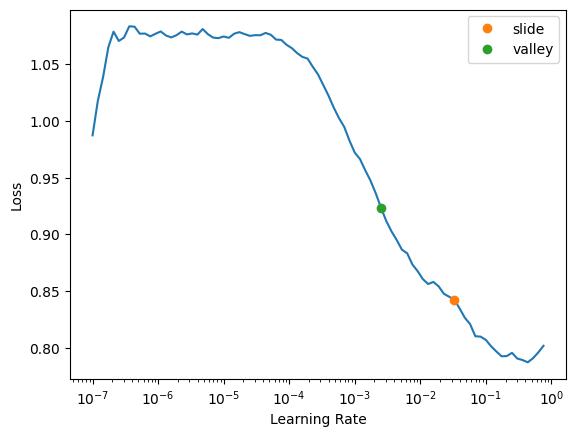

In [ ]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
%%time
learn.fit_one_cycle(10,0.012)


epoch,train_loss,valid_loss,accuracy,time
0,0.487815,0.461404,0.821538,00:16
1,0.479131,0.455091,0.826962,00:12
2,0.481454,0.459068,0.825263,00:12
3,0.474665,0.447203,0.827158,00:12
4,0.454744,0.444762,0.827681,00:12
5,0.449095,0.445679,0.824806,00:13
6,0.445982,0.442614,0.828400,00:12
7,0.440536,0.441824,0.829118,00:12
8,0.450727,0.437887,0.830099,00:12
9,0.429696,0.437135,0.830687,00:13


CPU times: user 2min 7s, sys: 945 ms, total: 2min 8s
Wall time: 2min 11s


In [ ]:
%%time
dl = learn.dls.test_dl(test_df)
#nn_preds = learn.get_preds(dl=dl)
#nn_preds_x = learn.get_preds()[0]
#a_preds, _ = learn.get_preds(dl=dl)
#nn_preds_y = a_preds.squeeze(1)
#nn_preds_z = nn_preds[0]

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

CPU times: user 69.2 ms, sys: 8.96 ms, total: 78.1 ms
Wall time: 145 ms


In [ ]:
target_preds = (nn_preds = learn.get_preds(dl=dl))[0]

test_df['Rings'] = target_preds
test_df.to_csv('submission.csv', columns=['Rings'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<ipython-input-47-c5606faad9ca>, line 1)

In [ ]:
nn_preds = learn.get_preds(dl=dl)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


With original dataset added

In [ ]:
train_final = pd.concat([train_df,original_df], axis=0)
test_final = pd.concat([test_df,original_df.drop('Target',axis=1)],axis=0)
train_final.shape,test_final.shape

# Scoring

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

In [ ]:
!rm submission.csv